Notebook reproducing results and code presented in the Tutorial "MaxCut QAOA", from Michael Streif, David Von Dollen, Michael Broughton @GoogleAI (see original work here : https://github.com/tensorflow/quantum/blob/research/qaoa/qaoa.ipynb). 

It shows an example of how to optimize variational parameters for QAOA using TFQ on a Pasqal Device. Please note that it uses the development version of Pasqal objects in Cirq, available at https://github.com/lhenriet/Cirq/tree/pasqal_new.

First we must install the required libraries

In [ ]:
#import tensorflow as tf
import cirq
#import tensorflow_quantum as tfq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
import cirq
from cirq.pasqal import PasqalNoiseModel

We can use QAOA to solve Max-cut. First we need to generate a 3-regular graph with 8 nodes upon which to find the Max-cut using QAOA. Let's visualize that graph.

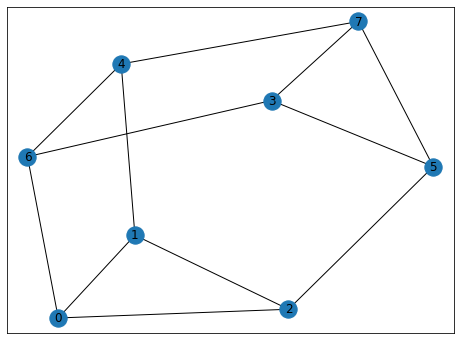

In [4]:
# generate a 3-regular graph with 8 nodes
maxcut_graph = nx.random_regular_graph(n=8, d=3)
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(maxcut_graph, ax=ax)

In [ ]:
from cirq.pasqal import PasqalVirtualDevice, PasqalDevice

p_qubits = cirq.GridQubit.square(3, 3)
p_device=PasqalVirtualDevice(control_radius=4, qubits=p_qubits)
p_named_device=PasqalDevice(qubits=cirq.NamedQubit.range(9, prefix='q'))

In [ ]:
# create layer of hadamards to initialize the superposition state of all 
# computational states
hadamard_circuit = cirq.Circuit(device=p_device)

for node in maxcut_graph.nodes():
    qubit = p_qubits[node]
    hadamard_circuit.append(cirq.H.on(qubit))

In [ ]:
# define the two parameters for one block of QAOA
qaoa_parameters = sympy.symbols('a b')

In [ ]:
# define the the mixing and the cost Hamiltonian, H_M and H_P
mixing_ham = 0
for node in maxcut_graph.nodes():
    qubit = cirq_qubits[node]
    mixing_ham += cirq.PauliString(cirq.X(qubit))

cost_ham = maxcut_graph.number_of_edges()/2
for edge in maxcut_graph.edges():
    qubit1 = cirq_qubits[edge[0]]
    qubit2 = cirq_qubits[edge[1]]
    cost_ham += cirq.PauliString(1/2*(cirq.Z(qubit1)*cirq.Z(qubit2)))

# generate the qaoa circuit
qaoa_circuit = tfq.util.exponential(operators = [cost_ham, mixing_ham], 
                                    coefficients = qaoa_parameters)

Subsequently, we use these ingredients to build our model. We note here in this case that QAOA has no input data and labels, as we have mapped our graph to the QAOA circuit. To use the TFQ framework we specify the Hadamard circuit as input and convert it to a TFQ tensor. We may then construct a tf.keras model using our QAOA circuit and cost in a TFQ PQC layer, and use a single instance sample for training the variational parameters of the QAOA with the Hadamard gates as an input layer and a target value of $0$ for our loss function. This translates into the following code:

In [ ]:
# define the model and training data
model_circuit, model_readout = qaoa_circuit, cost_ham
input_ = [hadamard_circuit]
input_ = tfq.convert_to_tensor(input_)
optimum = [0]

In [ ]:
# Build the Keras model.
optimum=np.array(optimum)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
model.add(tfq.layers.PQC(model_circuit, model_readout))
tfq.layers.PQC

To optimize the parameters of the ansatz state, we use a classical optimization routine. In general, it would be possible to use pre-calculated parameters  or to implement for QAOA tailored optimization routines. For this tutorial, we choose the Adam optimizer implemented in tensorflow. We also choose the mean absolute error as our loss function.

In [ ]:
model.compile(loss=tf.keras.losses.mean_absolute_error,
              optimizer=tf.keras.optimizers.Adadelta())
    
history = model.fit(input_,optimum,epochs=1000,verbose=1)

In [ ]:
# Read out the optimal paramters and sample from the final state 1000 times

params = model.trainable_variables
add = tfq.layers.AddCircuit()
output_circuit = add(input_, append =qaoa_circuit )

# Defining a sampler with PasqalNoise model
p_noise_model = PasqalNoiseModel(device=p_named_device)
my_sampler = cirq.DensityMatrixSimulator(noise=p_noise_model)

sample_layer1 = tfq.layers.Sample(backend=my_sampler)
output1 = sample_layer1(output_circuit,  symbol_names=qaoa_parameters, symbol_values = params, repetitions=1000)

# Defining an ideal sampler
sample_layer = tfq.layers.Sample()
output = sample_layer(output_circuit,  symbol_names=qaoa_parameters, symbol_values = params, repetitions=1000)

Next, we post-process the results of the variational procedure in the two cases. The first step is to translate the output in cut sets, for both the results. Then, we compare the results obtained to the ideal case.

In [ ]:
# Translate output in cut sets
cuts_qaoa = []

# We do that for the first sampler, that uses Pasqal noise model
for bit_string in output.values:
  temp = []
  for pos, bit in enumerate(bit_string):
    if bit==1:
      temp.append(pos)
  cuts_qaoa.append(temp)

# And also in the case of an ideal Quantum processor.
cuts_qaoa1 = []
for bit_string in output1.values:
  temp1 = []
  for pos, bit in enumerate(bit_string):
    if bit==1:
      temp1.append(pos)
  cuts_qaoa1.append(temp1)

# Generate a list with all possible subsets
from itertools import combinations
sub_lists = []
for i in range(0, len(maxcut_graph.nodes())+1):
  temp = [list(x) for x in combinations(maxcut_graph.nodes(), i)]
  sub_lists.extend(temp)

# Calculate the cut_size for all possible cuts
cut_size = []
for sub_list in sub_lists:
  cut_size.append(nx.algorithms.cuts.cut_size(maxcut_graph, sub_list))

# Calculate the cut_size for the cuts found with QAOA in the first case
cut_size_qaoa = []
for cut in cuts_qaoa:
  cut_size_qaoa.append(nx.algorithms.cuts.cut_size(maxcut_graph, cut))

# Calculate the cut_size for the cuts found with QAOA in the second case
cut_size_qaoa1 = []
for cut in cuts_qaoa1:
  cut_size_qaoa1.append(nx.algorithms.cuts.cut_size(maxcut_graph, cut))

Finally, we plot the two approximation ratio. Unsurprisingly, we see that the performances of the noisy simulation are not as good as in the ideal case.

In [ ]:
# Calculate the approximation ratio
print(np.mean(cut_size_qaoa)/np.max(cut_size))
print(np.mean(cut_size_qaoa1)/np.max(cut_size))